# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.811337,True,3.309030
1,-0.843788,True,1.696600
2,-0.105595,False,-1.178897
3,-1.413594,False,-3.104295
4,0.133226,True,5.475723
...,...,...,...
995,-0.201643,False,-1.487959
996,-0.449417,False,-2.353253
997,-0.286130,False,-0.682715
998,0.352646,True,3.729564


<Axes: xlabel='v0'>

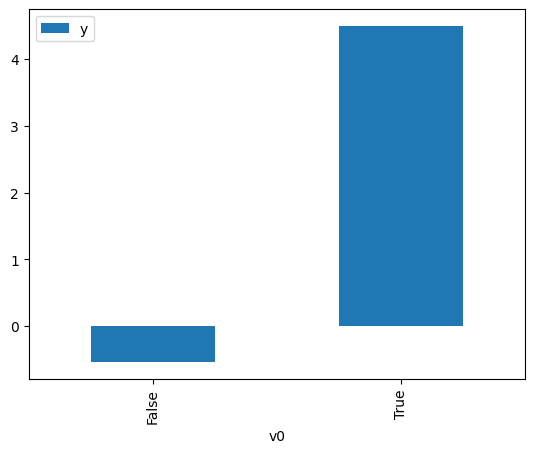

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

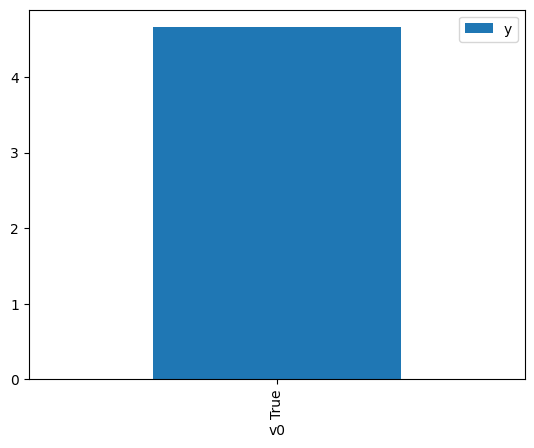

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.742606,False,1.655748,0.282163,3.544047
1,-2.936641,False,-5.053403,0.982783,1.017518
2,-0.442492,False,-1.341505,0.661450,1.511830
3,-2.134068,False,-4.199349,0.950667,1.051893
4,-1.168182,False,-1.723774,0.839117,1.191729
...,...,...,...,...,...
995,-0.941540,False,-2.448635,0.793312,1.260538
996,1.480361,False,3.497409,0.126531,7.903220
997,0.498983,False,0.977249,0.353402,2.829636
998,0.594622,False,0.341960,0.324422,3.082405


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.978295,True,4.419827,0.198652,5.033927
1,-0.813569,True,3.224790,0.236520,4.227975
2,-0.157999,True,5.271409,0.429271,2.329528
3,-1.551343,True,3.305663,0.102467,9.759276
4,-0.495967,True,3.503855,0.322541,3.100379
...,...,...,...,...,...
995,-1.551343,True,3.305663,0.102467,9.759276
996,-1.942201,True,2.970223,0.063034,15.864412
997,0.919675,True,6.534821,0.763749,1.309331
998,-0.737544,True,3.157608,0.255595,3.912432


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              7269.
Date:                Sat, 05 Apr 2025   Prob (F-statistic):                        0.00
Time:                        08:55:56   Log-Likelihood:                         -1399.5
No. Observations:                1000   AIC:                                      2803.
Df Residuals:                     998   BIC:                                      2813.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6426      0.030     55.175      0.000       1.584       1.701
x2             5.0276      0.050    100.217      0.000       4.929       5.126
==============================================================================
Omnibus:                        0.132   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.936   Jarque-Bera (JB):                0.063
Skew:                           0.002   Prob(JB):                        0.969
Kurtosis:                       3.039   Cond. No.                         1.71
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""